In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = r"C:\Users\ulrik\Desktop\progging\Datasets\cifar"

In [3]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
)

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
)

In [5]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]

cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0,2]]


In [6]:
connected_model = nn.Sequential(
                nn.Linear(3072, 1024),
                nn.Tanh(),
                nn.Linear(1024, 512),
                nn.Tanh(),
                nn.Linear(512, 128),
                nn.Tanh(),
                nn.Linear(128, 2))

In [7]:
first_model = nn.Sequential(
                    nn.Linear(3072, 512),
                    nn.Tanh(),
                    nn.Linear(512, 2),
                    nn.LogSoftmax(dim=1))

In [8]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [9]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [10]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [11]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [12]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

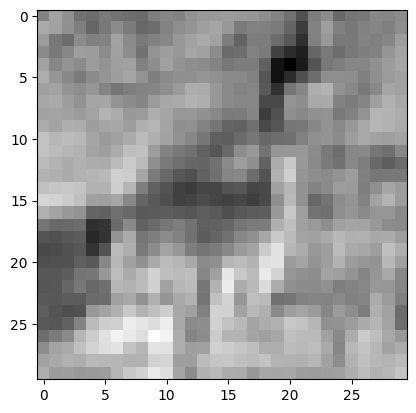

In [13]:
plt.imshow(output[0,0].detach(), cmap = "gray")

In [14]:
conv = nn.Conv2d(3,1, kernel_size=3, padding = 1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [15]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

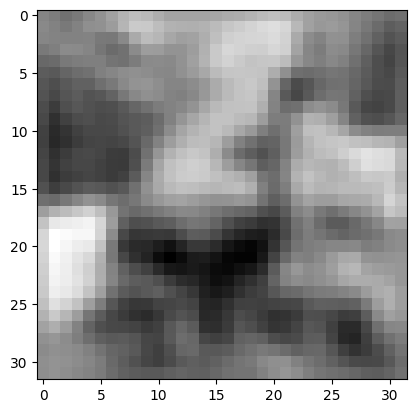

In [16]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap="gray")

In [17]:
conv = nn.Conv2d(3,1,kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1. , 0. , 1.],
                                   [-1. , 0. , 1.],
                                   [-1. , 0. , 1.]])
    conv.bias.zero_()

In [18]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [19]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16,8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2)
)

In [20]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        

    def forward(self, x):
        out = F.max_pool2d(torch.tanh((self.conv1(x))), 2)
        out = out = F.max_pool2d(torch.tanh((self.conv2(out))), 2)
        out = out.view(-1, 8 * 8 *8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [21]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [22]:
model(img.unsqueeze(0))

tensor([[ 0.2243, -0.2227]], grad_fn=<AddmmBackward0>)

In [23]:
import datetime

In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [25]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.
        for imgs, labels in train_loader:
            outputs = model(imgs) # feeds a batch through our model
            loss = loss_fn(outputs, labels) # Computes the loss we want to minimize 
            optimizer.zero_grad() # getting rid of gradients from last round
            loss.backward() # compute gradients of all parameter we want the newtork to learn
            optimizer.step() # Updates the model
            loss_train += loss.item() # Sums the losses we asw over the epoch. 
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

 

        

In [26]:
train_loader =torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()



In [27]:
training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-10-16 12:23:53.952762 Epoch 1, Training loss 0.5677982684533307
2023-10-16 12:24:46.676790 Epoch 10, Training loss 0.33806822149996546
2023-10-16 12:25:44.375540 Epoch 20, Training loss 0.29875728919817385
2023-10-16 12:26:43.457362 Epoch 30, Training loss 0.2727596443739666
2023-10-16 12:27:34.447710 Epoch 40, Training loss 0.2519437893750561
2023-10-16 12:28:24.660207 Epoch 50, Training loss 0.23367304017968998
2023-10-16 12:29:22.665483 Epoch 60, Training loss 0.21578178754088226
2023-10-16 12:30:21.546525 Epoch 70, Training loss 0.2022076943402837
2023-10-16 12:31:20.567139 Epoch 80, Training loss 0.1890289921574532
2023-10-16 12:32:14.577051 Epoch 90, Training loss 0.17276607339928865
2023-10-16 12:33:08.424271 Epoch 100, Training loss 0.15806344917910115


In [28]:
train_loader =torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader =torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [29]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                output = model(imgs)
                _, predicted = torch.max(output, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
            print("Accuracy {}: {:.2f}".format(name, correct/total))

validate(model, train_loader, val_loader)




Accuracy train: 0.94
Accuracy val: 0.88


In [30]:
data_path_store = "C:\\Users\\ulrik\\Desktop\\progging\\ML_models\\"

In [31]:
torch.save(model.state_dict(), data_path_store +"birds_vs_plane.pt")

In [32]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path_store + "birds_vs_plane.pt"))

<All keys matched successfully>

In [33]:
device = (torch.device("cuda") if torch.cuda.is_available()
          else torch.device("cpu"))

print(f"training device: {device}")

training device: cuda


In [34]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs) # feeds a batch through our model
            loss = loss_fn(outputs, labels) # Computes the loss we want to minimize 
            optimizer.zero_grad() # getting rid of gradients from last round
            loss.backward() # compute gradients of all parameter we want the newtork to learn
            optimizer.step() # Updates the model
            loss_train += loss.item() # Sums the losses we asw over the epoch. 
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [35]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
 
model = Net().to(device=device)                    
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
 
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)



2023-10-16 12:33:25.716317 Epoch 1, Training loss 0.590493970995496
2023-10-16 12:33:36.396206 Epoch 10, Training loss 0.3330935234097159
2023-10-16 12:33:48.178486 Epoch 20, Training loss 0.30355885596412
2023-10-16 12:33:59.864895 Epoch 30, Training loss 0.2795832906938662
2023-10-16 12:34:11.600829 Epoch 40, Training loss 0.2569713164476832
2023-10-16 12:34:23.318209 Epoch 50, Training loss 0.23631173770898467
2023-10-16 12:34:34.997076 Epoch 60, Training loss 0.2193534128889916
2023-10-16 12:34:46.752074 Epoch 70, Training loss 0.20250764427481183
2023-10-16 12:34:58.902065 Epoch 80, Training loss 0.188247285688379
2023-10-16 12:35:10.698908 Epoch 90, Training loss 0.17057515641638807
2023-10-16 12:35:22.272470 Epoch 100, Training loss 0.15945205555125408


In [36]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path_store
                                        + 'birds_vs_plane.pt'))



<All keys matched successfully>

In [37]:
device

device(type='cuda')

In [38]:
torch.cuda.device_count()

0

In [39]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear( 32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tan(self.fc1(out))
        out = self.fc2(out)
        return out

In [42]:
model = NetWidth()

In [50]:
sum(p.numel() for p in model.parameters())


38386

In [51]:
device

device(type='cuda')

In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001 # replace pow(2.0) with abs() 
            l2_norm = sum(p.pow(2.).sum() for p in model.paramers()) # for L1 regularization
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print("{} Epoch {}, Training loss {}".format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)
            ))

In [52]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [54]:
model = NetDropout()
model.eval()

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_dropout): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [55]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out




In [56]:
model = NetBatchNorm()


In [57]:
model.eval()

NetBatchNorm(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [58]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)            
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')      
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x




In [59]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
 
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

